<a href="https://colab.research.google.com/github/BenUCL/AI4Reefs-Workshop/blob/main/Audio_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Remember to save a copy of this notebook in your drive, otherwise any changes will be lost.

# **Machine learning with coral reef soundscape data**

We're going to use audio data you accessed in the introductory colab. This includes 151 one-minute audio files from healthy and degraded reefs in Indonesia.

Follow these steps:
- First, run the code up to the end of Step 1. Let the neural net extract features from the first several audio files and note the speed of this.
- Now, switch to a GPU runtime. This should be lightning fast compared to the original execution. Let the feature extraction run to completion.

# **Step 1: Feature extraction**
Our audio files are one-minute long. However, vggish will automatically cut these into 0.96s chunks, so we will get 62 chunks per file.





In [9]:
#@title Imports
import os # for handling files and directories
import librosa # for audio processing
import tensorflow as tf # for machine learning
import tensorflow_hub as hub # for machine learning
import numpy as np # for numerical processing
import pandas as pd # for handling dataframes
from tqdm import tqdm # for progress bar

random_seed = 0

### Mount your drive and add the path to the audio data once again

In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Directory containing audio files
audio_dir = '/content/drive/MyDrive/Reef soundscapes with AI/audio_dir'

### Load the VGGish model

We load the model from the kaggle link. Loads of pretrained models are easily available using kaggle and tensorflow like this, allowing you to use them for transfer learning.

In [4]:
model = hub.load('https://www.kaggle.com/models/google/vggish/frameworks/TensorFlow2/variations/vggish/versions/1')

## Extract features with the neural net

Now we run the main for loop to iterate over each file extract features using the pretrained neruel network.

To speed things up, we only use 40 healthy and 40 degraded files.

The results will be saved to a 'pandas dataframe', similar to a dataframe in R, and, to the 'extracted_features.csv' which should appear in the file tab on the left.

While the code is running, take a look at it and see how much you can understand. Try asking Chatgpt or Claude to explain parts you don't understand.

In [5]:
# Function to extract class from filename
def get_class(filename):
    if 'D' in filename:
        return 'degraded'
    elif 'H' in filename:
        return 'healthy'
    else:
        return 'unknown'

# Function to exctract features audio files and save these to a df
def process_audio_files(audio_dir, model):

    # List to store ouputs
    rows_list = []
    # Create outputs in loop
    for filename in tqdm(os.listdir(audio_dir), desc="Processing audio files"):
        if filename.endswith('.wav'):
            file_class = get_class(filename)

            # Process the file
            file_path = os.path.join(audio_dir, filename)
            audio, _ = librosa.load(file_path, sr=16000)
            vggish_features = model(audio).numpy()

            for i, embedding in enumerate(vggish_features):
                # Splitting the filename and embedding index
                embedding_index = i + 1
                row_data = {'filename': filename, 'embedding_index': embedding_index, 'class': file_class}
                for j, feature in enumerate(embedding):
                    row_data[f'feature_{j}'] = feature
                rows_list.append(row_data)

    # Create DataFrame from the list
    results_df = pd.DataFrame(rows_list)
    return results_df

# Process the audio files
results_df = process_audio_files(audio_dir, model)

# Save the results to a CSV file
results_df.to_csv('/content/extracted_features.csv', index=False)

Processing audio files: 100%|██████████| 153/153 [00:25<00:00,  6.09it/s]


That should have run super quick! Once you're done with the GPU on colab, its good practice to switch back to a standard runtime. Make sure to download the extracted_features.csv first! You can then re-upload this to your new runtime.

In [6]:
#@title Take a peek at the dataframe

# Load the csv as a dataframe
df = pd.read_csv('/content/extracted_features.csv')

# We add another column that encodes classes as integers for later
class_mapping = {'healthy': 1, 'degraded': 0}
df['encoded_class'] = df['class'].map(class_mapping)

# Place 'encoded_class' next to the 'class' column
cols = df.columns.tolist()
class_index = cols.index('class')
cols.insert(class_index + 1, cols.pop(cols.index('encoded_class')))
df = df[cols]

# Display the DataFrame to see the new column
df

,filename,embedding_index,class,encoded_class,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127
0,BaF1.1055H.1678278701.180827.3.35.wav,1,healthy,1,0.112779,-0.140025,0.805142,-0.065615,-0.088416,-0.439000,...,-0.382452,-0.017742,0.014537,-0.305372,-0.114973,0.177665,-0.052560,-0.379132,-0.261828,-0.446968
1,BaF1.1055H.1678278701.180827.3.35.wav,2,healthy,1,-0.060403,0.069760,0.860503,-0.060612,-0.138553,-0.561023,...,-0.659584,0.161767,-0.017911,-0.201018,0.149680,0.285722,-0.016425,-0.339612,-0.344196,-0.419009
2,BaF1.1055H.1678278701.180827.3.35.wav,3,healthy,1,-0.127920,0.192353,0.730804,-0.165487,-0.217085,-0.648741,...,-0.565424,0.145351,-0.039941,-0.137107,0.018933,0.207887,0.123601,-0.247874,-0.220400,-0.249677
3,BaF1.1055H.1678278701.180827.3.35.wav,4,healthy,1,-0.065161,0.026585,0.460514,-0.080269,-0.168232,-0.494129,...,-0.688468,-0.063568,-0.113589,-0.314809,-0.198444,0.420739,0.121526,-0.298712,-0.314043,-0.470217
4,BaF1.1055H.1678278701.180827.3.35.wav,5,healthy,1,-0.025853,0.012851,0.521478,-0.078034,-0.075855,-0.510772,...,-0.461958,-0.000688,0.035085,-0.195608,0.071777,0.172952,-0.015375,-0.404011,-0.208607,-0.354191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9419,BoF1.1328H.1678278701.180827.4.28.wav,58,healthy,1,-0.120777,-0.095520,0.436362,-0.029309,-0.310057,-0.636018,...,-0.513451,-0.164179,0.027442,-0.390421,0.001788,0.361329,0.047832,-0.528124,-0.382127,-0.410784
9420,BoF1.1328H.1678278701.180827.4.28.wav,59,healthy,1,-0.049574,0.180992,0.431224,0.101491,-0.134768,-0.421808,...,-0.785522,0.000022,-0.048159,-0.255709,-0.326678,0.400070,0.236952,-0.085104,-0.160943,-0.182631
9421,BoF1.1328H.1678278701.180827.4.28.wav,60,healthy,1,-0.090557,-0.013204,0.529907,-0.127749,-0.258891,-0.470468,...,-0.734391,-0.135330,-0.219490,-0.386520,-0.292850,0.713480,0.289085,-0.233190,-0.323606,-0.370681
9422,BoF1.1328H.1678278701.180827.4.28.wav,61,healthy,1,-0.193060,0.126399,0.403851,-0.005891,-0.189728,-0.519186,...,-0.578104,-0.027794,-0.132108,-0.243452,-0.442800,0.552004,0.361710,-0.161396,-0.146441,-0.261148


### Use colab to plot the df

Scroll to the right of the df table and you should see the plotting symbol in the top right.

Lets make a plot that shows the distribution of classes.

Questions
1. What is the approximate ratio of healthy or degreded?
2. How might this affect the metric we use for assessing a supervised classifer?

# **Step 2: Dimensionality reduction**

VGGish outputs feature embeddings that are 128 dimensions long (do you see the 128 new columns in our df?). This is quite a lot of features to put into simple classification or clustering algorithms. Dimensionality reduction can help compress these, reducing noise and merging correlated features.

We're going to reduce the dimensions by a factor of 4, down to 16. We will use 'Uniform Manifold Approximation' (UMAP).

UMAP is not a standard package on Colab so we need to start install it. This is typically using the terminal. We can use an '!' before code to run it as a terminal command.

In [7]:
# Install UMAP
!pip install umap-learn
import umap

In [10]:
# Number of dimensions to be output by UMAP
n_dims = 16

# Select only the feature columns (assuming they are named 'feature_0', 'feature_1', ...)
feature_cols = [col for col in df.columns if col.startswith('feature_')]
X = df[feature_cols]

# n_neighbors and min_dist are important parameters, but we can use common defaults
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=random_seed, n_components = n_dims)
umap_embedding = reducer.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### Visualise UMAP

A bonus of UMAP is that we can also use it visualise our data (though only in 2 or 3 dimensions).

This will plot recordings that sound similar close together, and recordings that sound different apart. This makes it a really great tool to explore your data. Note it doesn't directly create clusters.

Run the next cell and view the output.

Questions:
1. We've overlaid the class in this case, but usually in unsupervised learning you won't know the class, but you may have other meta data and features you could overlay (e.g time or data). Can you think of others that might be useful?
2. You might see some small groups of anomolies away from their main group. What could cause this in the context of audio or other data?
3. Can you think of one or two use cases where viewing the data like this could be useful?



In [11]:
# n_neighbors and min_dist are important parameters, but we can use common defaults, note n_components is set 2 as we're plotting in 2D
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=random_seed, n_components = 2)
umap_embedding_2d = reducer.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


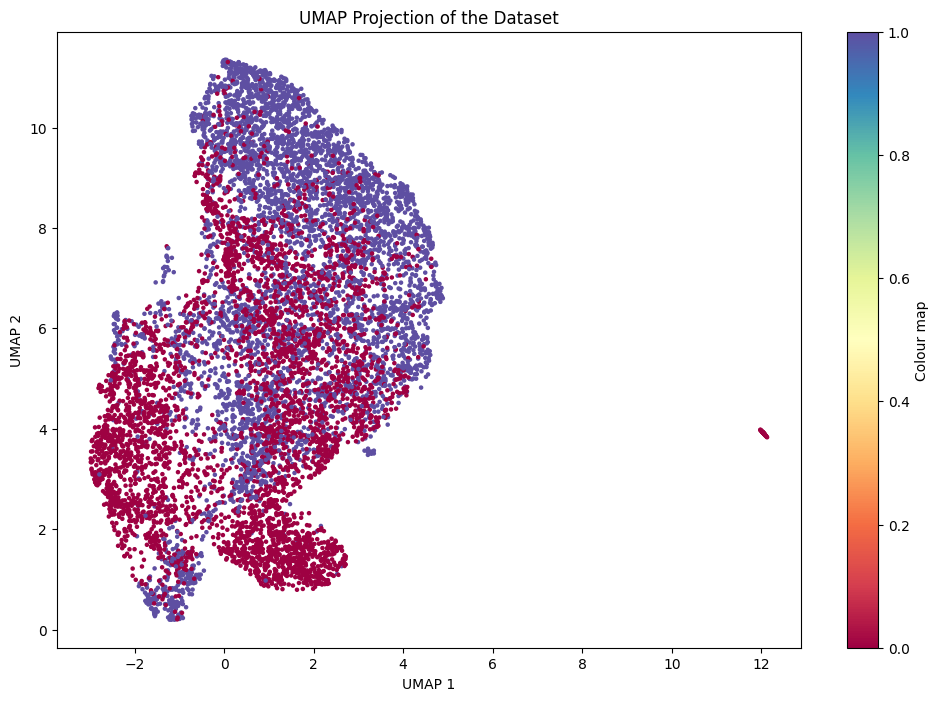

In [13]:
import matplotlib.pyplot as plt

# Plot the UMAP projection
c = df['encoded_class']
plt.figure(figsize=(12, 8))
plt.scatter(umap_embedding_2d[:, 0], umap_embedding_2d[:, 1], c=c, cmap='Spectral', s=5)
plt.colorbar(label='Colour map')
plt.title('UMAP Projection of the Dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

## **Step 3: Cluster the data**

Now we are going to perform unsupervised clustering on our dimension reduced ata. We'll start with k-means clustering. Like Random Forests for classification, this is always a safe bet to use for a first quick model.

Start by looking at the scikit-learn documentation and try get a quick understanding of k-means (https://scikit-learn.org/stable/modules/clustering.html#k-means). Stuck on anything? Ask ChatGPT! Its knowledge on commonly used approaches like this is very reliable.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


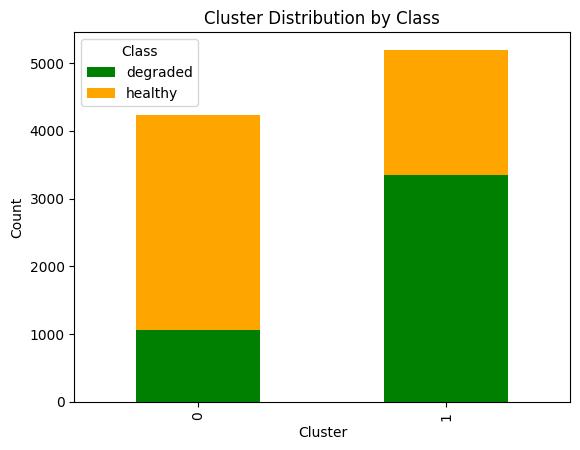

In [14]:
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns

# Set variables
num_clusters = 2

# Apply k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=random_seed)
clusters = kmeans.fit_predict(umap_embedding)

# Add the cluster information to the DataFrame
df['cluster'] = clusters

# Prepare data for the bar plot
cluster_class_counts = df.groupby(['cluster', 'class']).size().unstack().fillna(0)

# Create the bar plot
cluster_class_counts.plot(kind='bar', stacked=True, color=['green', 'orange'])
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Distribution by Class')
plt.legend(title='Class')
plt.show()


### Questions
1. Try varying the number of clusters. What do you see change?
2. What information can help you decide the number of clusters to set?
2. What can you intepret about how different healthy and degraded reefs sound by these results?
2. We know whether audio came from healthy or degraded reefs. Why is unsupervised learning still useful in place of supervised learning here?
3. HARDER: Now try using ChatGPT and/or the scikit learn clustering documentation (https://scikit-learn.org/stable/modules/clustering.html#k-means) to implement a different clustering algorithm. You will only need to modify the two lines of code underneath 'Apply k-means clustering'. Do this in a new cell below.

# **Advanced: Supervised learning**
1. Take the feature variables created earlier from the df (X). Create a labels variable from the 'encoded_class' column (use ChatGPT for help if needed). Check your labels variable looks correct.
2. Now, using these two variables of features and labels, copy in and adapt the relevant code from the intro colab to train a random forest classifier and report the accuracy.
3. This should be very accurate. Remember, we have 62 samples from each 1-min recording that likely sound similar. Why could this bias accuracy? How should we better handle this? Try using the 'groupby' function in pandas.
4. Due to the small class imbalance, we might want a different metric to accuracy? Why is this? Try and find some contenders and implement one of these (ask ChatGPT for help).
